In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from xgboost import XGBRegressor

#util functions
from utils.utils import *

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.describe()


,Average
count,544.000000
mean,100.660317
std,13.711767
min,64.171250
25%,89.386429
50%,102.886230
75%,111.793036
max,131.453333


In [4]:
train.head()

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,03/01/09,99.01,79.79,N.S.,76.19,84.02,70.07,81.66,57.83,68.94,51.67,70.74,53.88,65.55,46.75,69.700000
1,10/01/09,97.74,78.73,87.48,73.97,82.72,68.17,83.31,58.02,67.24,52.23,70.47,53.39,67.39,46.84,70.550000
2,17/01/09,95.95,71.01,87.66,71.01,80.58,67.16,82.25,57.49,69.64,52.48,71.66,53.18,69.51,48.04,69.830000
3,24/01/09,94.14,73.38,85.69,65.66,N.S.,65.57,80.87,54.59,N.S.,53.43,71.12,52.07,69.14,48.5,67.846667
4,31/01/09,91.45,70.39,N.S.,64.99,79.27,62.09,80.76,57.06,69.65,53.38,72.3,52.5,69.39,50.33,67.196923


In [5]:
train.isna().sum()

WeekEnding_Date             0
Kolkata_Average_Price       0
Kolkata_Ref_Price           2
Bangalore_Average_Price     0
Bangalore_Ref_Price         2
Cochin_Average_Price        0
Cochin_Ref_Price            3
Darjeeling_Average_Price    0
Darjeeling_Ref_Price        2
Ernakulam_Average_Price     0
Ernakulam_Ref_Price         1
Siliguri_Average_Price      1
Siliguri_Ref_Price          1
Guwahati_Average_Price      0
Guwahati_Ref_Price          0
Average                     0
dtype: int64

In [6]:
# len(train)
train.columns

Index(['WeekEnding_Date', 'Kolkata_Average_Price', 'Kolkata_Ref_Price',
       'Bangalore_Average_Price', 'Bangalore_Ref_Price',
       'Cochin_Average_Price', 'Cochin_Ref_Price', 'Darjeeling_Average_Price',
       'Darjeeling_Ref_Price', 'Ernakulam_Average_Price',
       'Ernakulam_Ref_Price', 'Siliguri_Average_Price', 'Siliguri_Ref_Price',
       'Guwahati_Average_Price', 'Guwahati_Ref_Price', 'Average'],
      dtype='object')

In [7]:
a = train.iloc[2,1:].tolist()

## the problem in hand seems to be that of regression(interpolation) of weekly prices for cities
1. predict/forecast rates for each of the average/ref price PER place
2. Get the avg of predictions for the date

### Problem 1:
input : **date**
output : **price**

### Problem 2: 
get the avg


## EDA , Impute missing values

### Since we know the avg column is the average of the cols 1:-1, we can use the formula to fill missing values

In [8]:
#convert date column to datetime
train['WeekEnding_Date']=pd.to_datetime(train['WeekEnding_Date'])
train = train[train.WeekEnding_Date>'2017-01-01']
# train = train[train.WeekEnding_Date<'2020-01-01']
#sort by ascending date
train.sort_values(by=['WeekEnding_Date']).reset_index(drop=True)

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,2017-01-04,NS,NS,106.49,119.11,120.34,140.78,136.6,116,106.38,91.59,110.1,98,95.66,83.15,110.350000
1,2017-01-07,165.76,168.49,150.69,154.87,135.59,111.33,103.98,114.66,72.06,96.19,88.4,98.93,74.31,84.6,115.704286
2,2017-01-14,137.42,139.57,119.67,128.57,119.96,119.06,115.75,118.93,108.48,94.44,107.22,94.73,101.62,79.5,113.208571
3,2017-01-21,138.95,131.62,118.2,115.34,113.58,116.51,119.11,119.64,106.54,96.8,108.3,97.91,100.75,78.17,111.530000
4,2017-01-28,131.53,122.06,111.18,115.69,109.11,110.25,121.13,121.41,105.43,102.74,109.01,101.11,99.08,80.16,109.992143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2019-08-06,151.61,156.67,146.91,153.37,147.83,145.44,120.12,112.83,92.16,76.98,105.16,91.57,84.63,67.13,118.029286
122,2019-09-02,124.27,119.08,120.36,104.53,115.83,103.48,124.53,123.73,97.97,94.85,103.63,101.46,88.44,73.91,106.862143
123,2019-09-03,115.79,NS,NS,99.3,107.78,92.72,121.82,121.39,100.44,93.96,106.52,103.78,92.33,71.05,102.240000
124,2019-11-05,152.57,165.65,134.76,146.06,149.81,134.17,122.98,115.81,98.29,81.65,109.36,94.33,89.81,70.66,118.993571


In [9]:
### lets get all sorts of null values out and change dtype of rest of them to float
# train['Kolkata_Average_Price'] = train['Kolkata_Average_Price'].apply(lambda x:float(x) if not re.match(r'[a-zA-Z]',x) else None)
cols = ['Kolkata_Average_Price','Kolkata_Ref_Price',
        'Bangalore_Average_Price', 'Bangalore_Ref_Price',
        'Cochin_Average_Price', 'Cochin_Ref_Price',
        'Darjeeling_Average_Price','Darjeeling_Ref_Price', 
        'Ernakulam_Average_Price','Ernakulam_Ref_Price', 
        'Siliguri_Average_Price', 'Siliguri_Ref_Price',
        'Guwahati_Average_Price', 'Guwahati_Ref_Price']
preprocess(train,cols)

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
418,2017-07-01,142.07,145.47,123.86,129.16,123.50,124.25,112.85,113.81,108.25,89.47,106.49,91.40,99.02,74.67,113.162143
419,2017-01-14,137.42,139.57,119.67,128.57,119.96,119.06,115.75,118.93,108.48,94.44,107.22,94.73,101.62,79.50,113.208571
420,2017-01-21,138.95,131.62,118.20,115.34,113.58,116.51,119.11,119.64,106.54,96.80,108.30,97.91,100.75,78.17,111.530000
421,2017-01-28,131.53,122.06,111.18,115.69,109.11,110.25,121.13,121.41,105.43,102.74,109.01,101.11,99.08,80.16,109.992143
422,2017-04-02,129.21,117.94,106.14,113.04,105.52,105.48,124.04,123.56,105.11,104.49,110.27,103.93,98.56,83.86,109.367857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,2019-11-05,152.57,165.65,134.76,146.06,149.81,134.17,122.98,115.81,98.29,81.65,109.36,94.33,89.81,70.66,118.993571
540,2019-05-18,147.74,159.89,134.50,146.36,148.81,142.88,122.98,113.00,96.47,78.46,111.36,90.39,90.96,66.68,117.891429
541,2019-05-25,149.69,155.28,134.29,142.67,147.25,149.11,122.78,111.20,94.61,77.33,109.20,92.87,87.72,66.49,117.177857
542,2019-01-06,144.51,150.81,138.45,151.35,149.70,151.40,122.82,111.12,93.01,77.14,109.69,91.66,86.60,68.00,117.590000


In [10]:
train.isna().sum()

WeekEnding_Date              0
Kolkata_Average_Price        7
Kolkata_Ref_Price           11
Bangalore_Average_Price      8
Bangalore_Ref_Price          8
Cochin_Average_Price        10
Cochin_Ref_Price            14
Darjeeling_Average_Price     7
Darjeeling_Ref_Price         7
Ernakulam_Average_Price      4
Ernakulam_Ref_Price          4
Siliguri_Average_Price       4
Siliguri_Ref_Price           4
Guwahati_Average_Price       1
Guwahati_Ref_Price           1
Average                      0
dtype: int64

In [11]:
train.sort_values(by=['WeekEnding_Date']).reset_index(drop=True)

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,2017-01-04,NaN,NaN,106.49,119.11,120.34,140.78,136.60,116.00,106.38,91.59,110.10,98.00,95.66,83.15,110.350000
1,2017-01-07,165.76,168.49,150.69,154.87,135.59,111.33,103.98,114.66,72.06,96.19,88.40,98.93,74.31,84.60,115.704286
2,2017-01-14,137.42,139.57,119.67,128.57,119.96,119.06,115.75,118.93,108.48,94.44,107.22,94.73,101.62,79.50,113.208571
3,2017-01-21,138.95,131.62,118.20,115.34,113.58,116.51,119.11,119.64,106.54,96.80,108.30,97.91,100.75,78.17,111.530000
4,2017-01-28,131.53,122.06,111.18,115.69,109.11,110.25,121.13,121.41,105.43,102.74,109.01,101.11,99.08,80.16,109.992143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2019-08-06,151.61,156.67,146.91,153.37,147.83,145.44,120.12,112.83,92.16,76.98,105.16,91.57,84.63,67.13,118.029286
122,2019-09-02,124.27,119.08,120.36,104.53,115.83,103.48,124.53,123.73,97.97,94.85,103.63,101.46,88.44,73.91,106.862143
123,2019-09-03,115.79,NaN,NaN,99.30,107.78,92.72,121.82,121.39,100.44,93.96,106.52,103.78,92.33,71.05,102.240000
124,2019-11-05,152.57,165.65,134.76,146.06,149.81,134.17,122.98,115.81,98.29,81.65,109.36,94.33,89.81,70.66,118.993571


In [12]:
train = fill_null(train)

column : Kolkata_Average_Price
idx : 0
column : Kolkata_Ref_Price
idx : 1
column : Bangalore_Average_Price
idx : 2
replacing row 90 on column Bangalore_Average_Price and value 102.81153900000004
column : Bangalore_Ref_Price
idx : 3
column : Cochin_Average_Price
idx : 4
column : Cochin_Ref_Price
idx : 5
replacing row 48 on column Cochin_Ref_Price and value 105.85230780000006
replacing row 91 on column Cochin_Ref_Price and value 104.37615320000009
column : Darjeeling_Average_Price
idx : 6
replacing row 8 on column Darjeeling_Average_Price and value 122.63076880000017
replacing row 29 on column Darjeeling_Average_Price and value 111.56307660000016
replacing row 69 on column Darjeeling_Average_Price and value 114.2261532
replacing row 94 on column Darjeeling_Average_Price and value 124.07999999999993
column : Darjeeling_Ref_Price
idx : 7
replacing row 30 on column Darjeeling_Ref_Price and value 111.15999999999985
replacing row 51 on column Darjeeling_Ref_Price and value 119.66692339999986


In [13]:
train.isna().sum()

WeekEnding_Date             0
Kolkata_Average_Price       0
Kolkata_Ref_Price           0
Bangalore_Average_Price     0
Bangalore_Ref_Price         0
Cochin_Average_Price        0
Cochin_Ref_Price            0
Darjeeling_Average_Price    0
Darjeeling_Ref_Price        0
Ernakulam_Average_Price     0
Ernakulam_Ref_Price         0
Siliguri_Average_Price      0
Siliguri_Ref_Price          0
Guwahati_Average_Price      0
Guwahati_Ref_Price          0
Average                     0
dtype: int64

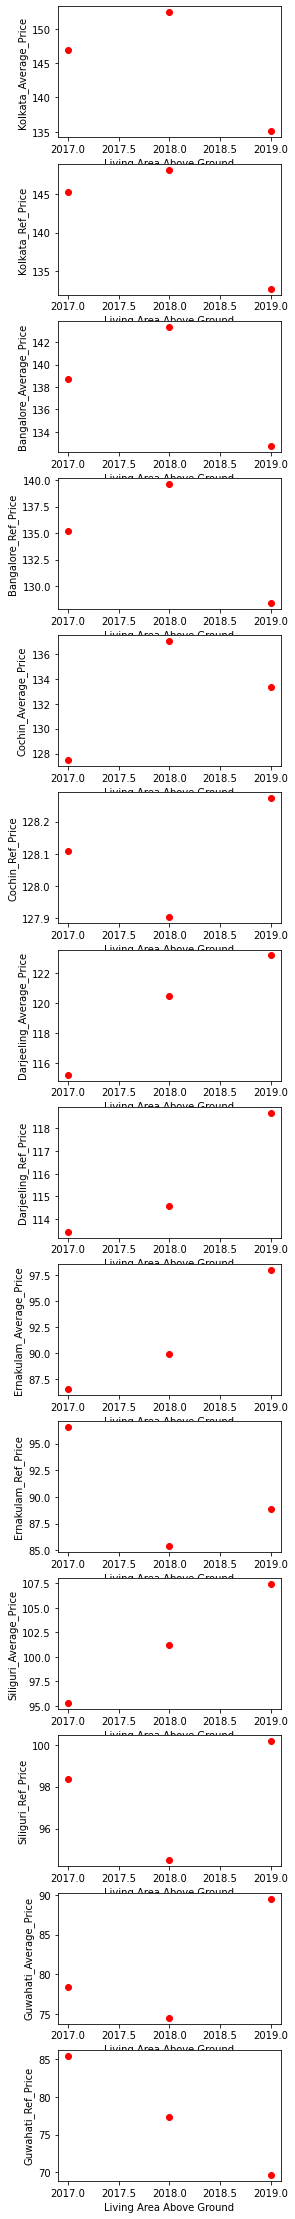

In [14]:
fig, ax = plt.subplots(14, figsize=(4,40 ))
train_by_year = train.groupby(train.WeekEnding_Date.map(lambda x: x.year)).mean()
for i in range(len(cols)):
    ax[i].scatter(train_by_year.index.tolist(),train_by_year[cols[i]].tolist(),  c = 'red')
    ax[i].set_xlabel("Living Area Above Ground")
    ax[i].set_ylabel(str(cols[i]))



### just to get test set preprocessed too

In [15]:
test = preprocess(test,cols)

### let us split the datetime input into individual features

In [16]:
train_year = train['WeekEnding_Date'].apply(lambda x:x.year).tolist()
train_month = train['WeekEnding_Date'].apply(lambda x:x.month).tolist()
train_day = train['WeekEnding_Date'].apply(lambda x:x.day).tolist()
train_weekday = train['WeekEnding_Date'].apply(lambda x:x.today().weekday()).tolist()

test['WeekEnding_Date']=pd.to_datetime(test['WeekEnding_Date'])
test_year = test['WeekEnding_Date'].apply(lambda x:x.year).tolist()
test_month = test['WeekEnding_Date'].apply(lambda x:x.month).tolist()
test_day = test['WeekEnding_Date'].apply(lambda x:x.day).tolist()
test_weekday = test['WeekEnding_Date'].apply(lambda x:x.today().weekday()).tolist()

In [17]:
test.isna().sum()

WeekEnding_Date              0
Kolkata_Average_Price       20
Kolkata_Ref_Price           20
Bangalore_Average_Price     20
Bangalore_Ref_Price         20
Cochin_Average_Price        20
Cochin_Ref_Price            20
Darjeeling_Average_Price    20
Darjeeling_Ref_Price        20
Ernakulam_Average_Price     20
Ernakulam_Ref_Price         20
Siliguri_Average_Price      20
Siliguri_Ref_Price          22
Guwahati_Average_Price      20
Guwahati_Ref_Price          20
Average                     29
dtype: int64

In [18]:
# errors_list(y_test,y_pred)

In [19]:
# dt = DecisionTreeRegressor()
# dt.fit(X_train, y_train)
# y_pred = dt.predict(X_test)
# errors_list(y_test,y_pred)

In [20]:
# from sklearn import linear_model
# reg = linear_model.Lasso(alpha=1)

# reg.fit(X_train, y_train)
# y_pred = reg.predict(X_test)
# errors_list(y_test,y_pred)

In [25]:


scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(2)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)

X_train = train['WeekEnding_Date'].map(datetime.datetime.toordinal)
X_train = pd.DataFrame({1:X_train.values,2:train_month,3:train_day,4:train_weekday})

X_train = scaler.fit_transform(X_train)
y_train = np.array(train.iloc[:,1:-1].values.tolist())

X_test = test['WeekEnding_Date'].map(datetime.datetime.toordinal)
X_test = pd.DataFrame({1:X_test.values,2:test_month,3:test_day,4:test_weekday})

# X_test = np.array(X_test)
X_test = scaler.fit_transform(X_test)

y_test = np.array(test.iloc[:,1:-1].values.tolist())
model = {}
error = {}
new_test = {}
reg2 = {}
for i in range(14):
    err = []
    reg2['svm'] = LinearSVR()
    reg2['rnn'] = RadiusNeighborsRegressor()
    reg2['knn'] = KNeighborsRegressor(n_neighbors=5)
    reg2['xgb'] = GradientBoostingRegressor()
    reg2['lasso'] = linear_model.Lasso()
    reg2['dt'] = DecisionTreeRegressor()
    y_train = np.array(train.iloc[:,i+1].values.tolist())
    y_test = np.array(test.iloc[:,i+1].values.tolist())
    for model in reg2.keys():
        new_test[model] = []
        error[model] = []
        reg2[model].fit(X_train, y_train)
        y_pred = reg2[model].predict(X_test)
        for j in range(len(y_test)):
            if not np.isnan(y_test[j]):
                err.append((y_pred[j]-y_test[j]))
            if np.isnan(y_test[j]):
                y_test[j]=y_pred[j]#-avg_error[i]
        new_test[model].append(y_test)
        error[model].append(err)

print(new_test)
new_test = pd.concat([pd.Series(new_test['lasso'][x]) for x in range(len(new_test['lasso']))],axis=1)

{'svm': [array([65.34      , 72.66436731, 78.12280393, 60.96771741, 67.73767398,
       73.1961106 , 78.65454722, 55.42982525, 70.1564595 , 72.96996672,
       78.42840334, 81.55      , 82.68      , 83.32      , 84.91      ,
       83.66069609, 61.19386129, 75.92049553, 78.73400276, 79.19      ,
       55.72163761, 85.73      , 78.50785888, 83.9662955 , 94.29      ,
       92.22      , 79.03960217, 84.49803879, 89.95647541])], 'rnn': [array([65.34      , 72.66436731, 78.12280393, 60.96771741, 67.73767398,
       73.1961106 , 78.65454722, 55.42982525, 70.1564595 , 72.96996672,
       78.42840334, 81.55      , 82.68      , 83.32      , 84.91      ,
       83.66069609, 61.19386129, 75.92049553, 78.73400276, 79.19      ,
       55.72163761, 85.73      , 78.50785888, 83.9662955 , 94.29      ,
       92.22      , 79.03960217, 84.49803879, 89.95647541])], 'knn': [array([65.34      , 72.66436731, 78.12280393, 60.96771741, 67.73767398,
       73.1961106 , 78.65454722, 55.42982525, 70.1564595 , 

In [26]:
avg = []
for i in range(len(new_test)):
    s =  (sum([x for x in new_test.iloc[i,:].values.tolist()]))/14
    avg.append(s)
    
pd.DataFrame({'Average':avg}).to_csv('my_submission_file.csv', index=False)

In [27]:
new_test


,0
0,65.340000
1,72.664367
2,78.122804
3,60.967717
4,67.737674
5,73.196111
6,78.654547
7,55.429825
8,70.156459
9,72.969967


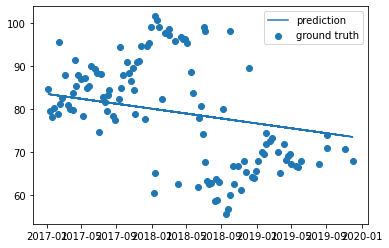

In [28]:
y_tp = reg2['lasso'].predict(X_train)
plt.scatter(train["WeekEnding_Date"].values, pd.DataFrame(y_train).values, label='ground truth')
plt.plot(train["WeekEnding_Date"].values, pd.DataFrame(y_tp).values, label='prediction')
plt.legend(loc='upper right')
plt.show()




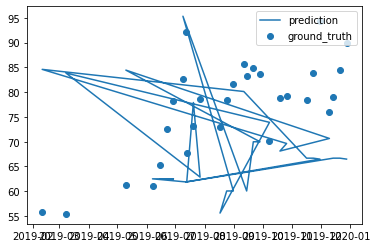

In [29]:
plt.scatter(test["WeekEnding_Date"].values, pd.DataFrame(y_test).values, label='ground_truth')
plt.plot(test["WeekEnding_Date"].values, pd.DataFrame(y_pred).values, label='prediction')
plt.legend(loc='upper right')
plt.show()